In [3]:
import pandas as pd
import glob
import cv2
import os
import csv
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
from keras.layers import Flatten, Dense
from keras.models import Model
from keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from tensorflow.keras import utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import keras
from keras import optimizers
import random

In [4]:
# Creating a dataframe out for our images to use for image recognition

image_direc = 'D:\GIT\classification_project\Personal Projects\moonphaseimages\MoonPhaseImages'

image_data = []

for root, dirs, files in os.walk(image_direc):
    for file in files:
        if file.endswith('.jpg'):                   # For loop iterates through my folder of images. If it ends with .jpg, add it to image_data
            image_path = os.path.join(root, file)
            label = os.path.basename(root)          # Make a label column with nthe basename of each file path
            image_data.append([image_path, label])

df = pd.DataFrame(image_data, columns =['Image Path', 'Label'])

df.to_csv('image_data.csv', index = False)

In [5]:
df['Image Path'] = df['Image Path'].str.replace('D:\\GIT\\classification_project\\Personal Projects\\moonphaseimages\\MoonPhaseImages\\', '') # Replacing entire filename from label column
df

,Image Path,Label
0,FirstQuarter.jpg,MoonPhaseImages
1,FirstQuarter10.jpg,MoonPhaseImages
2,FirstQuarter10_aug_1.jpg,MoonPhaseImages
3,FirstQuarter11.jpg,MoonPhaseImages
4,FirstQuarter11_aug_1.jpg,MoonPhaseImages
...,...,...
315,WaxingGibbous8.jpg,MoonPhaseImages
316,WaxingGibbous8_aug_1.jpg,MoonPhaseImages
317,WaxingGibbous9.jpg,MoonPhaseImages
318,WaxingGibbous9_aug_1.jpg,MoonPhaseImages


In [6]:
df['Label'] = df['Image Path'] # Making label and image path the same
df

,Image Path,Label
0,FirstQuarter.jpg,FirstQuarter.jpg
1,FirstQuarter10.jpg,FirstQuarter10.jpg
2,FirstQuarter10_aug_1.jpg,FirstQuarter10_aug_1.jpg
3,FirstQuarter11.jpg,FirstQuarter11.jpg
4,FirstQuarter11_aug_1.jpg,FirstQuarter11_aug_1.jpg
...,...,...
315,WaxingGibbous8.jpg,WaxingGibbous8.jpg
316,WaxingGibbous8_aug_1.jpg,WaxingGibbous8_aug_1.jpg
317,WaxingGibbous9.jpg,WaxingGibbous9.jpg
318,WaxingGibbous9_aug_1.jpg,WaxingGibbous9_aug_1.jpg


In [7]:
df['Label'] = df['Label'].str.replace('.jpg', '') # Replacing filetype with whitespace
df

,Image Path,Label
0,FirstQuarter.jpg,FirstQuarter
1,FirstQuarter10.jpg,FirstQuarter10
2,FirstQuarter10_aug_1.jpg,FirstQuarter10_aug_1
3,FirstQuarter11.jpg,FirstQuarter11
4,FirstQuarter11_aug_1.jpg,FirstQuarter11_aug_1
...,...,...
315,WaxingGibbous8.jpg,WaxingGibbous8
316,WaxingGibbous8_aug_1.jpg,WaxingGibbous8_aug_1
317,WaxingGibbous9.jpg,WaxingGibbous9
318,WaxingGibbous9_aug_1.jpg,WaxingGibbous9_aug_1


In [8]:
#Using regex to elimate all numbers to better differentiate class values.

df['Label'] = df['Label'].str.replace(r'\d+$', '', regex=True) # Using regex to replace all numbers with whitespace, actively creating correct labels for each image
df['Label']

0             FirstQuarter
1             FirstQuarter
2      FirstQuarter10_aug_
3             FirstQuarter
4      FirstQuarter11_aug_
              ...         
315          WaxingGibbous
316    WaxingGibbous8_aug_
317          WaxingGibbous
318    WaxingGibbous9_aug_
319     WaxingGibbous_aug_
Name: Label, Length: 320, dtype: object

In [9]:
df

,Image Path,Label
0,FirstQuarter.jpg,FirstQuarter
1,FirstQuarter10.jpg,FirstQuarter
2,FirstQuarter10_aug_1.jpg,FirstQuarter10_aug_
3,FirstQuarter11.jpg,FirstQuarter
4,FirstQuarter11_aug_1.jpg,FirstQuarter11_aug_
...,...,...
315,WaxingGibbous8.jpg,WaxingGibbous
316,WaxingGibbous8_aug_1.jpg,WaxingGibbous8_aug_
317,WaxingGibbous9.jpg,WaxingGibbous
318,WaxingGibbous9_aug_1.jpg,WaxingGibbous9_aug_


## Exploration


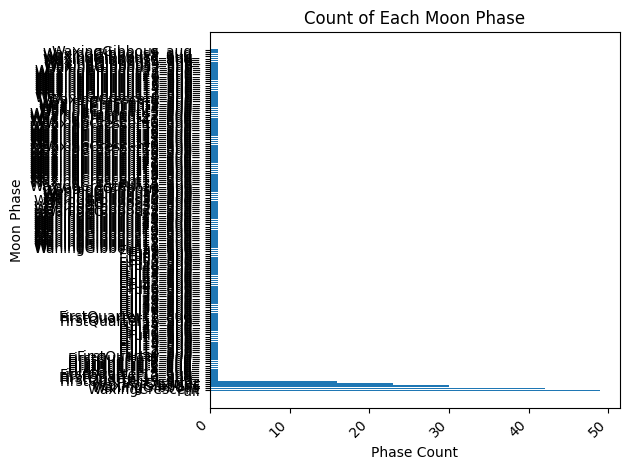

In [10]:
fig, ax = plt.subplots()             # The total value counts of each phase in my dataset 

type = df['Label'].value_counts()
bar_labels = df['Label'].unique()

ax.barh(type.index, type.values)

ax.set_xlabel('Phase Count')
ax.set_ylabel('Moon Phase')
ax.set_title('Count of Each Moon Phase')

plt.xticks(rotation = 45, ha= 'right') #rotating labels
plt.tight_layout() #adjusting layout 
plt.show()

## Creating Array for Images

In [11]:
# image_direc = 'D:\GIT\classification_project\Personal Projects\moonphaseimages\MoonPhaseImages'
# num_augmentations = 1                                                       # Number of augmented versions to create per image



#                                                                             # Iterate through all images
# for root, dirs, files in os.walk(image_direc):
#     for file in files:
#         if file.endswith('.jpg'):
#             # Load and process original image
#             image_path = os.path.join(root, file)
#             img = cv2.imread(image_path)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
#                                                                             # Create augmented versions
#             for i in range(num_augmentations):
#                                                                             # Creates a randomly translated version of each image
#                 rows, cols = img.shape[:2]
#                 tx = random.randint(int(-.25*cols), int(.25*cols))
#                 ty = random.randint(int(-.25*cols), int(.25*cols))
#                 M = np.float32([[1, 0, tx], [0, 1, ty]])
#                 augmented_img = cv2.warpAffine(img, M, (cols, rows))
                
#                                                                             # Convert back to BGR for saving
#                 augmented_img = cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR)
                
#                                                                              # Create new filename
#                 filename, ext = os.path.splitext(file)
#                 new_filename = f"{filename}_aug_{i+1}{ext}"
#                 save_path = os.path.join(root, new_filename)
                
#                                                                             # Save augmented image
#                 cv2.imwrite(save_path, augmented_img)


# total_images = sum(len(files) for _, _, files in os.walk(image_direc))
# print(f"Total images in dataset: {total_images}")

# image_data = []

# for root, dirs, files in os.walk(image_direc):
#     for file in files:
#         if file.endswith('.jpg'):
#             image_path = os.path.join(root, file)
#             label = os.path.basename(root)
#             image_data.append([image_path, label])

# df = pd.DataFrame(image_data, columns =['Image Path', 'Label'])  

In [12]:
moon_phases = os.listdir('D:\GIT\classification_project\Personal Projects\moonphaseimages\MoonPhaseImages')

array_jpg = []
name_jpg = []

for phase in (moon_phases):                # Creating a name dictionary if the file ends with .jpg
    if phase.endswith('.jpg'):        
        name_jpg.append(phase)
                                           # Adding arrays for each image into a new dictionary. Specifying a 128 by 128 pixel 
        loaded_phases = image.load_img(r'D:\GIT\classification_project\Personal Projects\moonphaseimages\MoonPhaseImages' + '\\' + phase, target_size = (128, 128))
        array_jpg.append(image.img_to_array(loaded_phases)/255)

In [13]:
name_jpg

['FirstQuarter.jpg',
 'FirstQuarter10.jpg',
 'FirstQuarter10_aug_1.jpg',
 'FirstQuarter11.jpg',
 'FirstQuarter11_aug_1.jpg',
 'FirstQuarter12.jpg',
 'FirstQuarter12_aug_1.jpg',
 'FirstQuarter13.jpg',
 'FirstQuarter13_aug_1.jpg',
 'FirstQuarter14.jpg',
 'FirstQuarter14_aug_1.jpg',
 'FirstQuarter15.jpg',
 'FirstQuarter15_aug_1.jpg',
 'FirstQuarter16.jpg',
 'FirstQuarter16_aug_1.jpg',
 'FirstQuarter2.jpg',
 'FirstQuarter2_aug_1.jpg',
 'FirstQuarter3.jpg',
 'FirstQuarter3_aug_1.jpg',
 'FirstQuarter4.jpg',
 'FirstQuarter4_aug_1.jpg',
 'FirstQuarter5.jpg',
 'FirstQuarter5_aug_1.jpg',
 'FirstQuarter6.jpg',
 'FirstQuarter6_aug_1.jpg',
 'FirstQuarter7.jpg',
 'FirstQuarter7_aug_1.jpg',
 'FirstQuarter8.jpg',
 'FirstQuarter8_aug_1.jpg',
 'FirstQuarter9.jpg',
 'FirstQuarter9_aug_1.jpg',
 'FirstQuarter_aug_1.jpg',
 'Full1.jpg',
 'Full10.jpg',
 'Full10_aug_1.jpg',
 'Full11.jpg',
 'Full11_aug_1.jpg',
 'Full12.jpg',
 'Full12_aug_1.jpg',
 'Full13.jpg',
 'Full13_aug_1.jpg',
 'Full14.jpg',
 'Full14_aug_1.

In [14]:
array_jpg # This is what each image looks like as an array. Each number depicts pixel color.

[array([[[0.00392157, 0.01568628, 0.04313726],
         [0.01176471, 0.03137255, 0.05490196],
         [0.02745098, 0.04705882, 0.07058824],
         ...,
         [0.01568628, 0.04313726, 0.06666667],
         [0.02352941, 0.05098039, 0.07450981],
         [0.05098039, 0.07843138, 0.10196079]],
 
        [[0.01568628, 0.03529412, 0.05882353],
         [0.01176471, 0.03137255, 0.05490196],
         [0.03529412, 0.05490196, 0.07843138],
         ...,
         [0.01568628, 0.04313726, 0.07450981],
         [0.        , 0.02745098, 0.06666667],
         [0.03921569, 0.06666667, 0.09019608]],
 
        [[0.01568628, 0.03529412, 0.05882353],
         [0.01176471, 0.03137255, 0.05490196],
         [0.01960784, 0.04705882, 0.07058824],
         ...,
         [0.01176471, 0.03921569, 0.07843138],
         [0.02352941, 0.05098039, 0.09019608],
         [0.05098039, 0.07843138, 0.11764706]],
 
        ...,
 
        [[0.02745098, 0.02745098, 0.05882353],
         [0.03137255, 0.03137255, 0.06274

In [ ]:
valid_classes = ['FirstQuarter', 'Full', 'WaningGibbous', 'WaxingCrescent', 'WaxingGibbous']
def get_class_name(filename):
    for class_name in valid_classes:
        if class_name in filename:
            return class_name
    return None


image_data = []
for root, dirs, files in os.walk(image_direc):
    for file in files:
        if file.endswith('.jpg'):
            image_path = os.path.join(root, file)
            # Extract class name from filename
            label = get_class_name(file)
            if label:  # Only add if we found a valid class name
                image_data.append([image_path, label])

df = pd.DataFrame(image_data, columns=['Image Path', 'Label'])

print(df['Label'].value_counts())

df.to_csv('image_data.csv', index=False)
df['Image Path'] = df['Image Path'].str.replace('D:\\GIT\\classification_project\\Personal Projects\\moonphaseimages\\MoonPhaseImages\\', '')


print(df.head(10))

Label
Full              98
WaxingCrescent    84
WaningGibbous     60
WaxingGibbous     46
FirstQuarter      32
Name: count, dtype: int64
                 Image Path         Label
0          FirstQuarter.jpg  FirstQuarter
1        FirstQuarter10.jpg  FirstQuarter
2  FirstQuarter10_aug_1.jpg  FirstQuarter
3        FirstQuarter11.jpg  FirstQuarter
4  FirstQuarter11_aug_1.jpg  FirstQuarter
5        FirstQuarter12.jpg  FirstQuarter
6  FirstQuarter12_aug_1.jpg  FirstQuarter
7        FirstQuarter13.jpg  FirstQuarter
8  FirstQuarter13_aug_1.jpg  FirstQuarter
9        FirstQuarter14.jpg  FirstQuarter


In [16]:
df

,Image Path,Label
0,FirstQuarter.jpg,FirstQuarter
1,FirstQuarter10.jpg,FirstQuarter
2,FirstQuarter10_aug_1.jpg,FirstQuarter
3,FirstQuarter11.jpg,FirstQuarter
4,FirstQuarter11_aug_1.jpg,FirstQuarter
...,...,...
315,WaxingGibbous8.jpg,WaxingGibbous
316,WaxingGibbous8_aug_1.jpg,WaxingGibbous
317,WaxingGibbous9.jpg,WaxingGibbous
318,WaxingGibbous9_aug_1.jpg,WaxingGibbous


## Array / DataFrame

In [17]:
np_array = np.array(array_jpg)
np_array

array([[[[0.00392157, 0.01568628, 0.04313726],
         [0.01176471, 0.03137255, 0.05490196],
         [0.02745098, 0.04705882, 0.07058824],
         ...,
         [0.01568628, 0.04313726, 0.06666667],
         [0.02352941, 0.05098039, 0.07450981],
         [0.05098039, 0.07843138, 0.10196079]],

        [[0.01568628, 0.03529412, 0.05882353],
         [0.01176471, 0.03137255, 0.05490196],
         [0.03529412, 0.05490196, 0.07843138],
         ...,
         [0.01568628, 0.04313726, 0.07450981],
         [0.        , 0.02745098, 0.06666667],
         [0.03921569, 0.06666667, 0.09019608]],

        [[0.01568628, 0.03529412, 0.05882353],
         [0.01176471, 0.03137255, 0.05490196],
         [0.01960784, 0.04705882, 0.07058824],
         ...,
         [0.01176471, 0.03921569, 0.07843138],
         [0.02352941, 0.05098039, 0.09019608],
         [0.05098039, 0.07843138, 0.11764706]],

        ...,

        [[0.02745098, 0.02745098, 0.05882353],
         [0.03137255, 0.03137255, 0.0627451 ]

In [18]:
flattened_array = np_array.reshape(np_array.shape[0], -1) # Flattening the array to turn a multi-dimensional array  into a single dimensional array fpr training
flattened_array.shape

(320, 49152)

In [19]:
moon_df = pd.DataFrame(flattened_array) # Making the array a dataframe
moon_df

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0.003922,0.015686,0.043137,0.011765,0.031373,0.054902,0.027451,0.047059,0.070588,0.007843,...,0.098039,0.043137,0.078431,0.113725,0.027451,0.054902,0.094118,0.019608,0.035294,0.078431
1,0.474510,0.639216,0.874510,0.482353,0.647059,0.882353,0.490196,0.654902,0.890196,0.470588,...,0.133333,0.023529,0.054902,0.098039,0.027451,0.058824,0.101961,0.031373,0.062745,0.105882
2,0.474510,0.635294,0.839216,0.501961,0.647059,0.854902,0.474510,0.635294,0.839216,0.470588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.184314,0.266667,0.349020,0.188235,0.270588,0.352941,0.184314,0.266667,0.349020,0.188235,...,0.035294,0.023529,0.027451,0.035294,0.023529,0.027451,0.035294,0.015686,0.019608,0.027451
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.478431,0.549020,0.643137,0.478431,0.549020,0.643137,0.474510,0.545098,0.639216,0.482353,...,0.109804,0.054902,0.090196,0.125490,0.023529,0.058824,0.094118,0.035294,0.070588,0.105882
316,0.435294,0.509804,0.568627,0.454902,0.529412,0.588235,0.450980,0.517647,0.580392,0.450980,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
317,0.278431,0.309804,0.360784,0.274510,0.305882,0.356863,0.282353,0.313726,0.364706,0.278431,...,0.066667,0.027451,0.047059,0.070588,0.027451,0.047059,0.070588,0.027451,0.047059,0.070588
318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
moon_phases_df = pd.concat([moon_df, df], axis = 1)
moon_phases_df

,0,1,2,3,4,5,6,7,8,9,...,49144,49145,49146,49147,49148,49149,49150,49151,Image Path,Label
0,0.003922,0.015686,0.043137,0.011765,0.031373,0.054902,0.027451,0.047059,0.070588,0.007843,...,0.078431,0.113725,0.027451,0.054902,0.094118,0.019608,0.035294,0.078431,FirstQuarter.jpg,FirstQuarter
1,0.474510,0.639216,0.874510,0.482353,0.647059,0.882353,0.490196,0.654902,0.890196,0.470588,...,0.054902,0.098039,0.027451,0.058824,0.101961,0.031373,0.062745,0.105882,FirstQuarter10.jpg,FirstQuarter
2,0.474510,0.635294,0.839216,0.501961,0.647059,0.854902,0.474510,0.635294,0.839216,0.470588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,FirstQuarter10_aug_1.jpg,FirstQuarter
3,0.184314,0.266667,0.349020,0.188235,0.270588,0.352941,0.184314,0.266667,0.349020,0.188235,...,0.027451,0.035294,0.023529,0.027451,0.035294,0.015686,0.019608,0.027451,FirstQuarter11.jpg,FirstQuarter
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,FirstQuarter11_aug_1.jpg,FirstQuarter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.478431,0.549020,0.643137,0.478431,0.549020,0.643137,0.474510,0.545098,0.639216,0.482353,...,0.090196,0.125490,0.023529,0.058824,0.094118,0.035294,0.070588,0.105882,WaxingGibbous8.jpg,WaxingGibbous
316,0.435294,0.509804,0.568627,0.454902,0.529412,0.588235,0.450980,0.517647,0.580392,0.450980,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,WaxingGibbous8_aug_1.jpg,WaxingGibbous
317,0.278431,0.309804,0.360784,0.274510,0.305882,0.356863,0.282353,0.313726,0.364706,0.278431,...,0.047059,0.070588,0.027451,0.047059,0.070588,0.027451,0.047059,0.070588,WaxingGibbous9.jpg,WaxingGibbous
318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,WaxingGibbous9_aug_1.jpg,WaxingGibbous


In [21]:
moon_encoded = pd.get_dummies(df, columns = ['Label'])     # Get dummies creates new columns for each class, astype changes it to binary to easily confirm whether or not that image is that class
moon_encoded[['Label_FirstQuarter','Label_Full','Label_WaningGibbous','Label_WaxingCrescent','Label_WaxingGibbous']].astype(int) 

,Label_FirstQuarter,Label_Full,Label_WaningGibbous,Label_WaxingCrescent,Label_WaxingGibbous
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
315,0,0,0,0,1
316,0,0,0,0,1
317,0,0,0,0,1
318,0,0,0,0,1


In [22]:
x = np_array.reshape(np_array.shape[0], 128, 128, 3) # Creating x and y from training. x is the array for each image and y is the correct classes.
y = moon_encoded.drop(['Image Path'], axis = 1)
x.shape, y.shape

((320, 128, 128, 3), (320, 5))

In [23]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25) # Splitting data into training and testing. 25% of the data is used for testing while 75% is used for training.
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((240, 128, 128, 3), (80, 128, 128, 3), (240, 5), (80, 5))

## Modelling

In [24]:
model = Sequential()
model.add(layers.Conv2D(64, kernel_size = (3, 3), input_shape = (128, 128, 3), activation = 'relu'))  #64 filters. Convolutional window 3, 3. 128 by 128 pixels, 3 color ways. RGB. Relu for promotion of non-linearity.

model.add(layers.Flatten())                        # Flattening previous layer.
model.add(layers.Dense(64, activation = 'relu'))   # Adding 3 32-neuron fully connected layers.
model.add(layers.Dense(64, activation = 'relu'))   # The more layers, the more model complexity the model can understand.
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax')) # 5 nueron output layer for 5 moon phases

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['recall']) # Using Adam optimzer with base learning rate.
model.summary()     # Categorcal crossentropy for multi class predictions and recall to determine how many true positives are being predicted. 
    

d:\GIT\classification_project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1016064)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    65,028,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,038,597 (248.10 MB)

 Trainable params: 65,038,597 (248.10 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(xtrain, ytrain, epochs = 10, validation_data = [xtest, ytest]) # Training model. Running through dataset 10 times.

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 565ms/step - loss: 5.9115 - recall: 0.1197 - val_loss: 1.7655 - val_recall: 0.0750
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 510ms/step - loss: 1.5883 - recall: 0.1510 - val_loss: 1.3993 - val_recall: 0.2875
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 500ms/step - loss: 1.1137 - recall: 0.3875 - val_loss: 1.1731 - val_recall: 0.2125
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 494ms/step - loss: 0.9181 - recall: 0.3346 - val_loss: 1.1119 - val_recall: 0.3875
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 501ms/step - loss: 0.6925 - recall: 0.6131 - val_loss: 1.0312 - val_recall: 0.4500
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step - loss: 0.4974 - recall: 0.7833 - val_loss: 0.9994 - val_recall: 0.4625
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 496ms/step - loss: 0.4012 - recall: 0.8012 - val_loss: 1.2293 - val_recall: 0.5625
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - loss: 0.2877 - recall: 0.8949 - val_loss: 1.0085 - val_recall: 0.4500
Epoch 9/10
8/8 ━━━━━━━━━

In [26]:
moon_phase_pred = model.predict(xtest) # Making predictions.
moon_phase_pred

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


array([[3.55948731e-02, 9.29936230e-01, 1.31892301e-02, 6.98289659e-05,
        2.12097857e-02],
       [8.58575459e-06, 4.25709231e-06, 2.20709975e-08, 9.99893308e-01,
        9.38102385e-05],
       [8.06661628e-05, 7.50379078e-03, 9.04290844e-03, 9.83342648e-01,
        2.99297099e-05],
       [3.82605940e-02, 1.86090797e-01, 8.21016580e-02, 2.93886160e-06,
        6.93544030e-01],
       [4.51332936e-03, 9.20078814e-01, 6.13904893e-02, 2.11888197e-04,
        1.38054602e-02],
       [3.95353163e-05, 4.67103018e-06, 2.68960356e-08, 9.99867320e-01,
        8.84949259e-05],
       [5.65204978e-01, 1.36888344e-02, 1.84253324e-02, 2.62972590e-05,
        4.02654618e-01],
       [3.55537073e-03, 7.82401189e-02, 5.92627155e-04, 9.17063773e-01,
        5.48077340e-04],
       [3.43010388e-02, 6.01090431e-01, 1.49914771e-01, 2.09331244e-01,
        5.36241569e-03],
       [4.57642045e-07, 2.73372600e-04, 1.67226483e-06, 9.99724329e-01,
        1.64590162e-07],
       [3.75344634e-01, 5.6405

In [27]:
moon_phase_pred_labels = moon_phase_pred.argmax(axis=-1) # Highest predicted class of the full array predicted to give us one class predictions.
moon_phase_pred_labels

array([1, 3, 3, 4, 1, 3, 0, 3, 1, 3, 1, 2, 0, 1, 1, 3, 4, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 0, 3, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 4, 0,
       0, 3, 2, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 4, 0, 1, 1, 1, 3, 2, 1, 1,
       3, 3, 1, 4, 0, 1, 3, 1, 3, 3, 1, 1, 3, 3])

In [28]:
print(ytest[:10])
print(moon_phase_pred_labels[:10]) 

     Label_FirstQuarter  Label_Full  Label_WaningGibbous  \
102               False        True                False   
238               False       False                False   
146               False       False                 True   
316               False       False                False   
165               False       False                 True   
236               False       False                False   
290               False       False                False   
277               False       False                False   
202               False       False                False   
256               False       False                False   

     Label_WaxingCrescent  Label_WaxingGibbous  
102                 False                False  
238                  True                False  
146                 False                False  
316                 False                 True  
165                 False                False  
236                  True                Fals

In [29]:
#Listing class lables
class_labels = ['Label_FirstQuarter','Label_Full','Label_WaningGibbous','Label_WaxingCrescent','Label_WaxingGibbous']

#integer class label for each row
ytest_labels = ytest[class_labels].idxmax(axis = 1)

class_int = {label: idx for idx, label in enumerate(class_labels)}
ytest_integer = ytest_labels.map(class_int).values

ytest_integer

array([1, 3, 2, 4, 2, 3, 4, 4, 3, 3, 3, 3, 0, 0, 1, 3, 4, 0, 1, 2, 1, 4,
       1, 1, 1, 2, 2, 4, 3, 1, 0, 2, 2, 2, 2, 3, 4, 1, 1, 2, 2, 1, 4, 0,
       0, 3, 2, 3, 3, 2, 4, 2, 2, 1, 3, 3, 1, 4, 0, 2, 1, 2, 3, 2, 3, 1,
       3, 1, 4, 4, 0, 3, 3, 1, 2, 3, 1, 1, 1, 3])

In [30]:
precision = precision_score(ytest_integer, moon_phase_pred_labels, average = 'macro') # Precision score
print(precision)

0.7556620209059234


In [31]:
accuracy = accuracy_score(ytest_integer, moon_phase_pred_labels) # Accuracy score
accuracy

0.6125

# Model Testing

In [32]:
phase_names = ['First Quarter', 'Full Moon', 'Waning Gibbous','Waxing Crescent','Waxing Gibbous']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


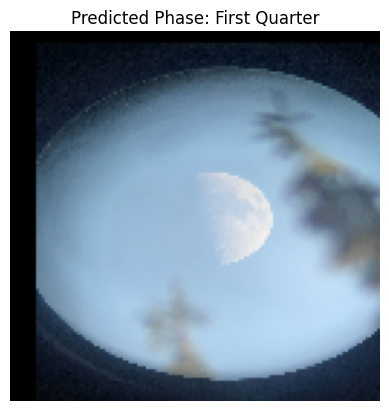

In [33]:
test_img = array_jpg[18]                                             # This function gives us an image from the dataset and a prediction based off of the model.
test_pred = np.expand_dims(test_img, axis=0)
predicted_phase = phase_names[np.argmax(model.predict(test_pred))]


plt.imshow(test_img)
plt.title(f"Predicted Phase: {predicted_phase}")
plt.axis('off')  
plt.show()                                                          

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


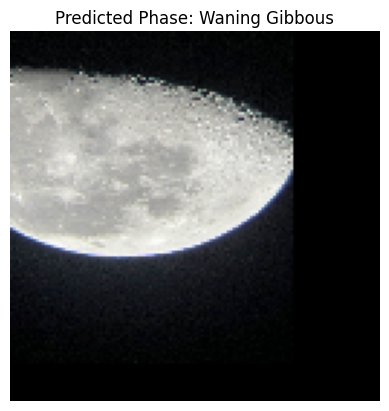

In [34]:
test_img = array_jpg[134]
test_pred = np.expand_dims(test_img, axis=0)
predicted_phase = phase_names[np.argmax(model.predict(test_pred))]


plt.imshow(test_img)
plt.title(f"Predicted Phase: {predicted_phase}")
plt.axis('off') 
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


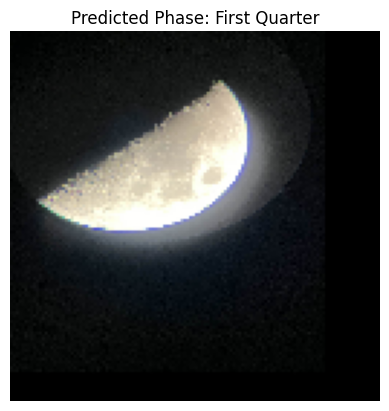

In [35]:
test_img = array_jpg[10]
test_pred = np.expand_dims(test_img, axis=0)
predicted_phase = phase_names[np.argmax(model.predict(test_pred))]


plt.imshow(test_img)
plt.title(f"Predicted Phase: {predicted_phase}")
plt.axis('off') 
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


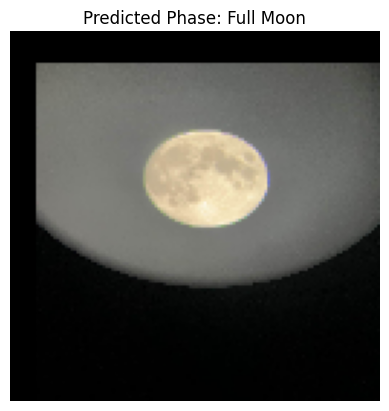

In [36]:
test_img = array_jpg[104]
test_pred = np.expand_dims(test_img, axis=0)
predicted_phase = phase_names[np.argmax(model.predict(test_pred))]


plt.imshow(test_img)
plt.title(f"Predicted Phase: {predicted_phase}")
plt.axis('off')  
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


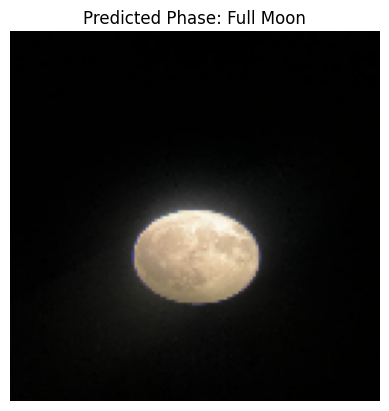

In [37]:
test_img = array_jpg[41]
test_pred = np.expand_dims(test_img, axis=0)
predicted_phase = phase_names[np.argmax(model.predict(test_pred))]


plt.imshow(test_img)
plt.title(f"Predicted Phase: {predicted_phase}")
plt.axis('off')  
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


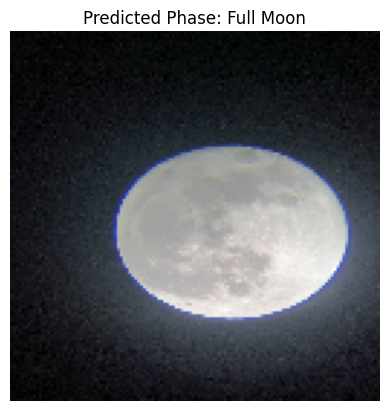

In [38]:
test_img = array_jpg[79]
test_pred = np.expand_dims(test_img, axis=0)
predicted_phase = phase_names[np.argmax(model.predict(test_pred))]


plt.imshow(test_img)
plt.title(f"Predicted Phase: {predicted_phase}")
plt.axis('off')  
plt.show()

In [39]:
print(classification_report(ytest_integer, moon_phase_pred_labels)) # Classification report is a good way to generalize how well the model differentiates classes.

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.44      0.90      0.59        20
           2       0.75      0.16      0.26        19
           3       0.71      0.71      0.71        21
           4       1.00      0.50      0.67        12

    accuracy                           0.61        80
   macro avg       0.76      0.63      0.62        80
weighted avg       0.71      0.61      0.58        80



## Data Augmentation

In [40]:
import cv2

The goal of these functions will be the create new data samples using existing samples. This will help increase the robustness of the model.

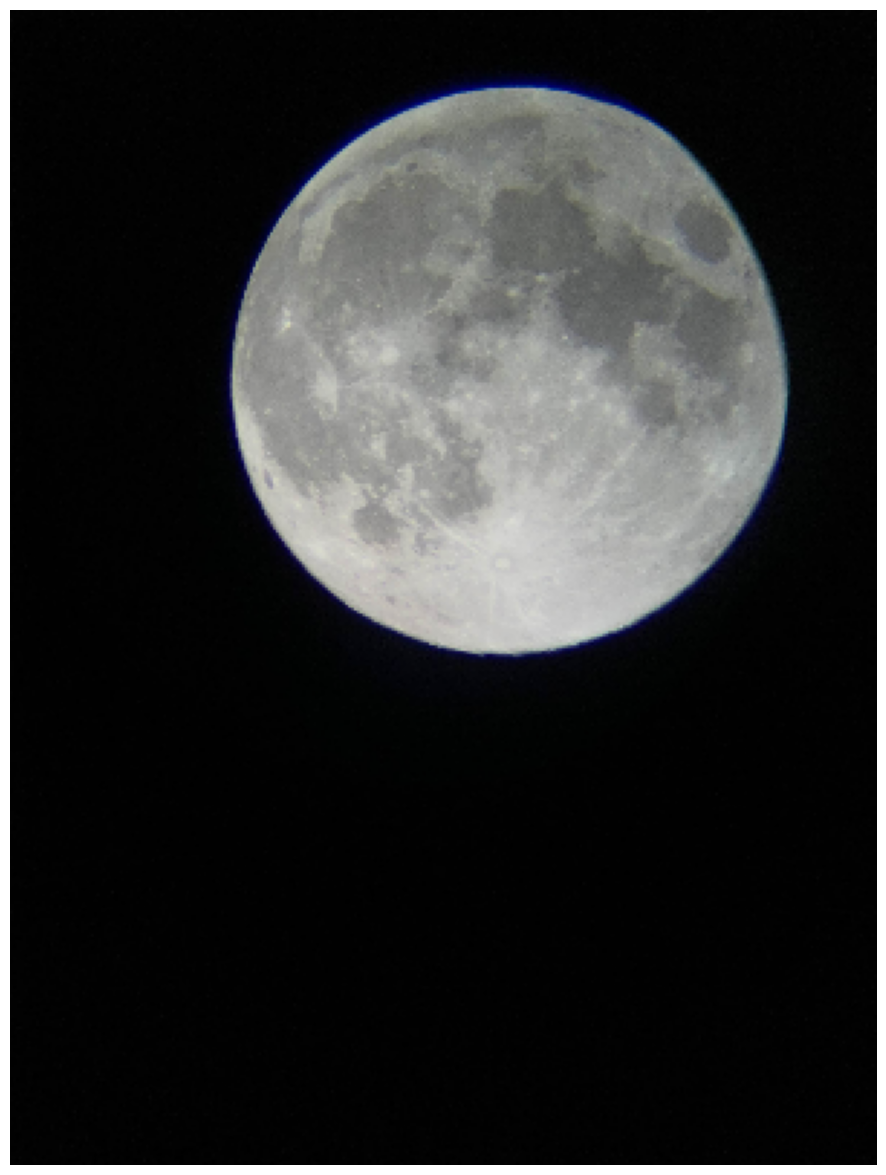

In [41]:
#original image for data augmentation

image = cv2.imread('D:\GIT\classification_project\Personal Projects\moonphaseimages\MoonPhaseImages\Full33.jpg') 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (300, 400))
rows, cols = image.shape[:2]
plt.figure(figsize = (15, 15))
plt.axis('off')
plt.imshow(image)

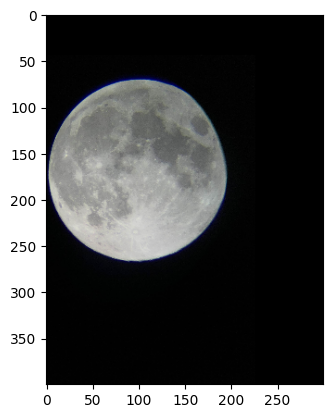

In [42]:
import random
tx = random.randint(-.25*cols, .25*cols) 
ty = random.randint(-.25*cols, .25*cols)
# Random number from x axis and y axis to move the image

M = np.float32([[1, 0, tx], [0, 1, ty]])
changed_img = cv2.warpAffine(image, M, (cols, rows))
# Warpaffine to apply change to image matrix
plt.imshow(changed_img)

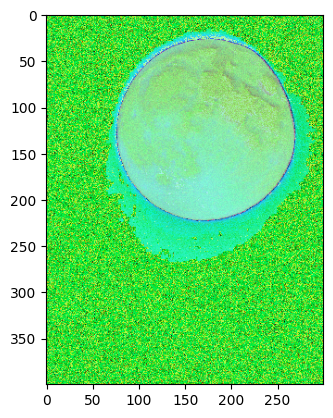

In [43]:
aug_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(aug_img) # Separating the color channels to be able to specify different ranges for each one.

h += np.random.randint(0, 100, size = (rows, cols), dtype= np.uint8)
s += np.random.randint(0, 20, size = (rows, cols), dtype= np.uint8)
v += np.random.randint(0, 10, size = (rows, cols), dtype= np.uint8)

aug_img = cv2.merge([h, s, v])
aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2HSV)
plt.imshow(aug_img)